In [7]:
import numpy as np
import pandas as pd
from tqdm import tqdm, trange

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import plotly.express as px

Read *influence_data.csv*, build the mapping from musicians to genres.

In [2]:
info_columns = ["danceability", "energy", "valence", "tempo", "loudness", "mode", "key", "acousticness",
                "instrumentalness", "liveness", "speechiness", "duration_ms"]

raw_style_data = pd.read_csv("influence_data.csv")
musician_dict = dict()
m = np.shape(raw_style_data)[0]
for i in range(m):
    if musician_dict.get(raw_style_data["influencer_id"][i], -1) == -1:
        musician_dict[raw_style_data["influencer_id"][i]] = raw_style_data["influencer_main_genre"][i]
    if musician_dict.get(raw_style_data["follower_id"][i], -1) == -1:
        musician_dict[raw_style_data["follower_id"][i]] = raw_style_data["follower_main_genre"][i]

Read *full_music_data.csv*, construct the genre list of music.

In [3]:
raw_full_data = pd.read_csv("full_music_data.csv")
artists_id = raw_full_data["artists_id"].values
genre_list = []
n = np.shape(artists_id)[0]
for i in range(n):
    temp, flag = artists_id[i][1:-1].split(','), False
    for x in temp:
        if musician_dict.get(int(x.lstrip(' ')), -1) != -1:
            genre_list.append(musician_dict[int(x.lstrip(' '))])
            flag = True
            break
    if not flag:
        genre_list.append("Unknown")

genres = pd.unique(genre_list)

Scale raw data to range $[0, 1]$, which helps to stablize the training.

In [4]:
scaler = MinMaxScaler()
X = scaler.fit_transform(raw_full_data[info_columns].values)

In practice, we find that:
* FastICA and PCA both show poor performance in visualization with either 2D or 3D scatters.
* TSNE seems great in visualization, but it cannot give a linear transformer and runs very slowly.

Therefore, we choose Factor Analysis (FA) to reduce the dimension of raw data here.

In [5]:
# dimension_reducer = FastICA(n_components = 3, tol = 1e-4)
dimension_reducer = FactorAnalysis(n_components = 3, tol = 0.05, max_iter = 1000)
# dimension_reducer = TSNE(n_components = 3)
# dimension_reducer = PCA(n_components = 2)

# dimension_reducer = LinearDiscriminantAnalysis(n_components = 2)
# Z = dimension_reducer.fit_transform(X, genre_list)
# params, centers = lda.coef_, lda.means_

Z = dimension_reducer.fit_transform(X)

D:\Anaconda3\lib\site-packages\sklearn\decomposition\_factor_analysis.py:243: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


In [8]:
weights = dimension_reducer.components_
df = pd.DataFrame(weights.T, columns = ['Component_'+str(i) for i in range(np.shape(weights)[0])], index = info_columns)
df.to_csv("P2_transform_coefficients.csv")

In [24]:
for n in range(1, 6):
    dimension_reducer = FactorAnalysis(n_components = n, tol = 0.2, max_iter = 300)
    Z = dimension_reducer.fit_transform(X)
    score = dimension_reducer.score(X)
    print("Num of Components: {}, Score: {:.2f}".format(n, score))

Num of Components: 1, Score: 5.20


D:\Anaconda3\lib\site-packages\sklearn\decomposition\_factor_analysis.py:243: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


Num of Components: 2, Score: 5.44


D:\Anaconda3\lib\site-packages\sklearn\decomposition\_factor_analysis.py:243: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


Num of Components: 3, Score: 5.50


D:\Anaconda3\lib\site-packages\sklearn\decomposition\_factor_analysis.py:243: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


Num of Components: 4, Score: 5.57
Num of Components: 5, Score: 5.60


D:\Anaconda3\lib\site-packages\sklearn\decomposition\_factor_analysis.py:243: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


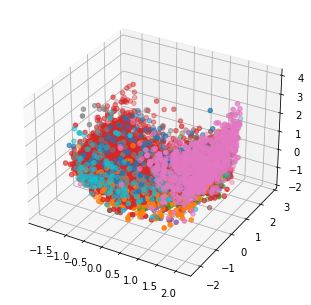

In [7]:
if dimension_reducer.n_components == 3:
    fig = plt.figure()
    ax = Axes3D(fig)
else:
    plt.figure()
for g in range(len(genres)):
    indices = []
    for i in range(5000):
        if genre_list[i] == genres[g]:
            indices.append(i)
    if dimension_reducer.n_components == 3:
        ax.scatter3D(Z[indices, 0], Z[indices, 1], Z[indices, 2])
    else:
        plt.scatter(Z[indices, 0], Z[indices, 1])
plt.show()
plt.legends = genres

In [9]:
plt.savefig("FA_transform.eps", dpi=600)

<Figure size 432x288 with 0 Axes>

*AutoEncoder* is also a decent method for dimension reduction.  
However, it falls short in interpretability, and thus we do not adopt it in our proposal. Codes are available below.

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

class AutoEncoder(nn.Module):
    def __init__(self, n_dims, n_components, hidden_units = 20):
        super(AutoEncoder, self).__init__()
        self.n_components = n_components
        self.hidden_units = hidden_units
        self.encoder = nn.Sequential(nn.Linear(n_dims, hidden_units),
                                 nn.ReLU(),
                                 nn.Linear(hidden_units, n_components),
                                 nn.ReLU()
                                )
        self.decoder = nn.Sequential(nn.Linear(n_components, hidden_units),
                                 nn.ReLU(),
                                 nn.Linear(hidden_units, n_dims)
                                )
    
    def forward(self, X):
        Z = self.encoder(X)
        X_rec = self.decoder(Z)
        return Z, X_rec
    
    def encode(self, X):
        return self.encoder(X)
    
    def get_params(self):
        return {"n_components": self.n_components,
               "hidden_units": self.hidden_units}

In [15]:
enc = AutoEncoder(np.shape(X)[1], 3)
Xt = torch.FloatTensor(X)
criterion = nn.MSELoss()
optimizer = optim.Adam(enc.parameters(), lr = 1e-2, weight_decay = 5e-4)
n_epochs = 20

for ep in range(n_epochs):
    optimizer.zero_grad()
    X_enc, X_rec = enc(Xt)
    loss = criterion(X_rec, Xt) + torch.mean(torch.ones(X_enc.size()) / X_enc**2)
    loss.backward()
    optimizer.step()
    
    if (ep+1) % 5 == 0:
        print("Epoch: {}, Loss: {:.3f}".format(ep+1, loss.item()))


Z = enc.encode(Xt).detach().numpy()

Epoch: 5, Loss: inf
Epoch: 10, Loss: inf
Epoch: 15, Loss: inf
Epoch: 20, Loss: 15.355


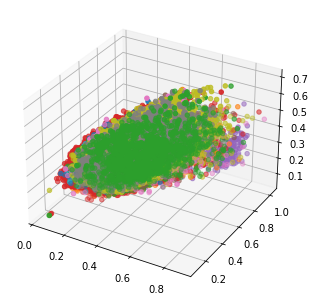

In [16]:
params = enc.get_params()
if params["n_components"] == 3:
    fig = plt.figure()
    ax = Axes3D(fig)
else:
    plt.figure()
for g in genres:
    indices = []
    for i in range(n):
        if genre_list[i] == g:
            indices.append(i)
    if params["n_components"] == 3:
        ax.scatter3D(Z[indices, 0], Z[indices, 1], Z[indices, 2])
    else:
        plt.scatter(Z[indices, 0], Z[indices, 1])
plt.show()